In [23]:
import datetime as dt

import pandas as pd
import numpy as np
import matplotlib
matplotlib.use('qt4agg')
import matplotlib.pyplot as plt

data_dir = '../data/'

%matplotlib inline

/Users/araichev/.virtualenvs/tumeke_koha/lib/python3.5/site-packages/matplotlib/__init__.py:1350: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [2]:
parser = lambda date: pd.datetime.strptime(date, '%d-%m-%Y')
f = pd.read_csv(data_dir + 'transactions.csv', parse_dates=['Date'], date_parser=parser)

# Rename columns for convenience
columns1 = {
  c: c.lower().strip().replace(' ', '_')
  for c in f.columns
  }
columns2 = {
  'memo/description': 'memo',
  'amount_(credit)': 'credit',
  'amount_(debit)': 'debit',
  }
f = f.rename(columns=columns1).rename(columns=columns2)

f.dtypes
f.head().T


,0,1,2,3,4
account_number,38-9008-0749578-00,38-9008-0749578-00,38-9008-0749578-00,38-9008-0749578-00,38-9008-0749578-00
date,2014-05-05 00:00:00,2014-05-07 00:00:00,2014-05-11 00:00:00,2014-05-14 00:00:00,2014-05-21 00:00:00
memo,CASH DEPOSIT ;KOHA,AP#4978135 TO TANGLEBALL INCORPORATED ;Pay TAN...,PAY Brian Phillips Ltd ;10904 sundries,PAY Brian Phillips Ltd ;121611freigh,AP#4978135 TO TANGLEBALL INCORPORATED ;Pay TAN...
source_code_(payment_type),NaN,NaN,NaN,NaN,NaN
tp_ref,NaN,NaN,NaN,NaN,NaN
tp_part,NaN,NaN,NaN,NaN,rent
tp_code,NaN,NaN,NaN,NaN,NaN
op_ref,NaN,NaN,NaN,NaN,rent
op_part,NaN,NaN,NaN,NaN,tumeke
op_code,NaN,NaN,NaN,NaN,fortnightly


In [12]:
# Search for non-grant earnings
cond1 = f['credit'] > 0  # Some credit
cond2 = ~f['memo'].str.contains('Auckland Transport|Auckland Council') # Not from Auckland agency
mask = cond1 & cond2
f[mask]

,account_number,date,memo,source_code_(payment_type),tp_ref,tp_part,tp_code,op_ref,op_part,op_code,op_name,op_bank_account_number,credit,debit,amount,balance
0,38-9008-0749578-00,2014-05-05,CASH DEPOSIT ;KOHA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,75.0,NaN,75.0,2862.71
7,38-9008-0749578-00,2014-06-08,FROM Y C TAYLOR ;Yvette,NaN,Yvette,NaN,NaN,NaN,NaN,NaN,Y C TAYLOR,38-9009-0309937-00,40.0,NaN,40.0,2166.71
12,38-9008-0749578-00,2014-07-28,CASH DEPOSIT ;KOHA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,110.0,NaN,110.0,1842.21
15,38-9008-0749578-00,2014-08-04,CASH DEPOSIT ;KOHA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,80.0,NaN,80.0,1700.71
18,38-9008-0749578-00,2014-08-26,Bill Payment VODERBERG BRY ;,BP,NaN,NaN,NaN,NaN,NaN,NaN,VODERBERG BRY,01-0258-0092870-00,20.0,NaN,20.0,1585.21
22,38-9008-0749578-00,2014-09-26,CASH DEPOSIT ;KOHA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,85.0,NaN,85.0,1190.21
23,38-9008-0749578-00,2014-09-29,Direct Credit 4L3J28CN4HRFNZD TransferC Paypal...,DC,4L3J28CN4HRF,NZD Transfer,C,NaN,NaN,NaN,Paypal Inc,03-0104-0974184-00,161.9,NaN,161.9,1352.11
28,38-9008-0749578-00,2014-11-07,CASH DEPOSIT ;,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,45.0,NaN,45.0,3417.11
30,38-9008-0749578-00,2014-11-21,CASH DEPOSIT ;KOHA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,115.0,NaN,115.0,3372.11
34,38-9008-0749578-00,2014-12-23,CASH DEPOSIT ;KOHA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,NaN,100.0,3852.11


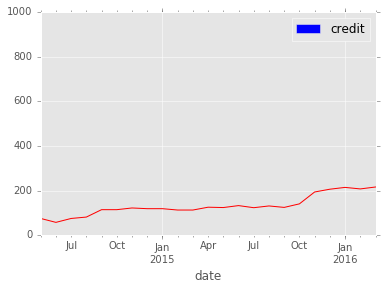

In [33]:
credit = f.loc[mask][['date', 'credit']].copy()
credit['date'] = pd.to_datetime(credit['date'])
credit = credit.set_index('date')#.dropna().sort_index()
credit

monthly_credit = credit.resample('M').sum()
expanding_mean = monthly_credit.expanding(min_periods=1).mean() 

ax1 = monthly_credit.plot(kind='bar', color='blue')
expanding_mean.plot(color='red', ax=ax1, legend=0) 